# Guidelines for Open-Loop Evaluation of InternVLA-A1

## Download dataset in lerobot v3.0 format

In [1]:
import os
from getpass import getpass

# set HF_HOME
hf_home = input("Enter HF_HOME cache directory: ").strip()

# set HF_TOKEN
hf_token = getpass("Enter your Huggingface token: ").strip()

os.environ["HF_HOME"] = hf_home
os.environ["HF_TOKEN"] = hf_token

# Keep your existing setting if you want online access
os.environ["HF_HUB_OFFLINE"] = "0"

print("HF_HOME =", os.environ.get("HF_HOME"))

HF_HOME = /root/.cache/huggingface/lerobot


In [2]:
!hf auth login --token $HF_TOKEN

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: write).
The token `internvla` has been saved to /root/.cache/huggingface/lerobot/stored_tokens
Your token has been saved to /root/.cache/huggingface/lerobot/token
Login successful.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Downloading example dataset in lerobot v3.0 format

In [3]:
!hf download \
  InternRobotics/InternData-A1 \
  real_lerobotv30/genie1/Genie1-Place_Markpen.tar.gz \
  --repo-type dataset \
  --local-dir temp_data_dir

temp_data_dir/real_lerobotv30/genie1/Genie1-Place_Markpen.tar.gz


In [4]:
!mkdir -p ${HF_HOME}/real_lerobotv30/genie1/
!tar -xzf temp_data_dir/real_lerobotv30/genie1/Genie1-Place_Markpen.tar.gz -C ${HF_HOME}/real_lerobotv30/genie1/

## Load InternVLA-A1-3B model

In [5]:
from pathlib import Path
import torch
from lerobot.configs.policies import PreTrainedConfig
from lerobot.policies.InternVLA_A1_3B import QwenA1Config, QwenA1Policy

ckpt_path = Path("Jia-Zeng/InternVLA-A1-3B-FineTuned-Place_Markpen")
config = PreTrainedConfig.from_pretrained(ckpt_path)
config.compile_model = False
config.compile_mode = "reduce-overhead"
dtype = torch.float32
assert isinstance(config, QwenA1Config)
policy = QwenA1Policy.from_pretrained(
    config=config, 
    pretrained_name_or_path=ckpt_path, 
)
policy.cuda()
policy.to(dtype)
policy.eval()

/user/user/zengjia/miniconda3/envs/internvla_a1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


QwenA1Policy(
  (model): QwenA1(
    (qwen3_vl_with_expert): Qwen3VLWithExpertModel(
      (und_expert): Qwen3VLForConditionalGeneration(
        (model): Qwen3VLModel(
          (visual): Qwen3VLVisionModel(
            (patch_embed): Qwen3VLVisionPatchEmbed(
              (proj): Conv3d(3, 1024, kernel_size=(2, 16, 16), stride=(2, 16, 16))
            )
            (pos_embed): Embedding(2304, 1024)
            (rotary_pos_emb): Qwen3VLVisionRotaryEmbedding()
            (blocks): ModuleList(
              (0-23): 24 x Qwen3VLVisionBlock(
                (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
                (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
                (attn): Qwen3VLVisionAttention(
                  (qkv): Linear(in_features=1024, out_features=3072, bias=True)
                  (proj): Linear(in_features=1024, out_features=1024, bias=True)
                )
                (mlp): Qwen3VLVisionMLP(
                  (linear

## Load the LeRobot dataset and configure its normalization statistics

In [6]:
import os
import numpy as np
from lerobot.configs.train import TrainPipelineConfig
from lerobot.datasets.factory import make_dataset
from lerobot.datasets.utils import write_json, load_json, cast_stats_to_numpy
from lerobot.transforms.core import UnNormalizeTransformFn
from lerobot.utils.constants import OBS_IMAGES, OBS_STATE, ACTION
from huggingface_hub import hf_hub_download

os.environ["HF_HUB_OFFLINE"] = "1" 
cfg = TrainPipelineConfig.from_pretrained(ckpt_path)
root_dir = os.environ['HF_HOME']
cfg.dataset.repo_id = f"{root_dir}/real_lerobotv30/genie1/Genie1-Place_Markpen"
cfg.dataset.use_external_stats = False
action_mode = cfg.dataset.action_mode
dataset, _ = make_dataset(cfg)

if Path(ckpt_path).is_dir():
        stats_file = Path(ckpt_path) / "stats.json"
        if not stats_file.exists():
            raise FileNotFoundError(f"stats.json not found in {ckpt_path}")
else:
    stats_file = hf_hub_download(
        repo_id=str(ckpt_path),
        filename="stats.json",
    )
stats = cast_stats_to_numpy(load_json(stats_file)[dataset.meta.robot_type])
dataset.meta.stats.update(stats)

stat_keys = ['min', 'max', 'mean', 'std']
action_stat = {stat_key: np.concatenate([
    dataset.meta.stats["actions.joint.position"][stat_key], 
    dataset.meta.stats["actions.effector.position"][stat_key]
], axis=-1) for stat_key in stat_keys}
state_stat = {stat_key: np.concatenate([
    dataset.meta.stats["observation.states.joint.position"][stat_key], 
    dataset.meta.stats["observation.states.effector.position"][stat_key]
], axis=-1) for stat_key in stat_keys}
act_unnorm_fn = UnNormalizeTransformFn(
    selected_keys=[ACTION], 
    mode="mean_std", 
    norm_stats={ACTION: action_stat}, 
)
state_unnorm_fn = UnNormalizeTransformFn(
    selected_keys=[OBS_STATE], 
    mode="mean_std", 
    norm_stats={OBS_STATE: state_stat}, 
)

rank=0/1, repo_ids_for_this_rank:
[rank 0] repo_id = /root/.cache/huggingface/lerobot/real_lerobotv30/genie1/Genie1-Place_Markpen
Hydrating transform NormalizeTransformFn with dataset.meta.stats (robot_type=a2d) and selected_keys (selected_keys=['observation.states.joint.position', 'observation.states.effector.position', 'actions.joint.position', 'actions.effector.position'])
Hydrating transform ComposeFieldsTransform with mapping (robot_type=a2d)
Hydrating transform DeltaActionTransformFn with mapping and mask (robot_type=a2d)
Hydrating transform RemapImageKeyTransformFn with mapping (robot_type=a2d)


## Inference

episode: 0
from_idx: 0, to_idx: 591
compute sample 0
compute sample 50
compute sample 100
compute sample 150
compute sample 200
compute sample 250
compute sample 300
compute sample 350
compute sample 400
compute sample 450
compute sample 500
compute sample 550
episode: 1
from_idx: 591, to_idx: 1144
compute sample 591
compute sample 641
compute sample 691
compute sample 741
compute sample 791
compute sample 841
compute sample 891
compute sample 941
compute sample 991
compute sample 1041
compute sample 1091
compute sample 1141
episode: 2
from_idx: 1144, to_idx: 1704
compute sample 1144
compute sample 1194
compute sample 1244
compute sample 1294
compute sample 1344
compute sample 1394
compute sample 1444
compute sample 1494
compute sample 1544
compute sample 1594
compute sample 1644
compute sample 1694
{'MSE': [2.7240235795034096e-05, 3.2551284675719216e-05, 6.240149559744168e-06],
 'Average MSE': np.float64(2.2010556676832493e-05),
 'MSE on joints': [4.1189773583028e-06,
                

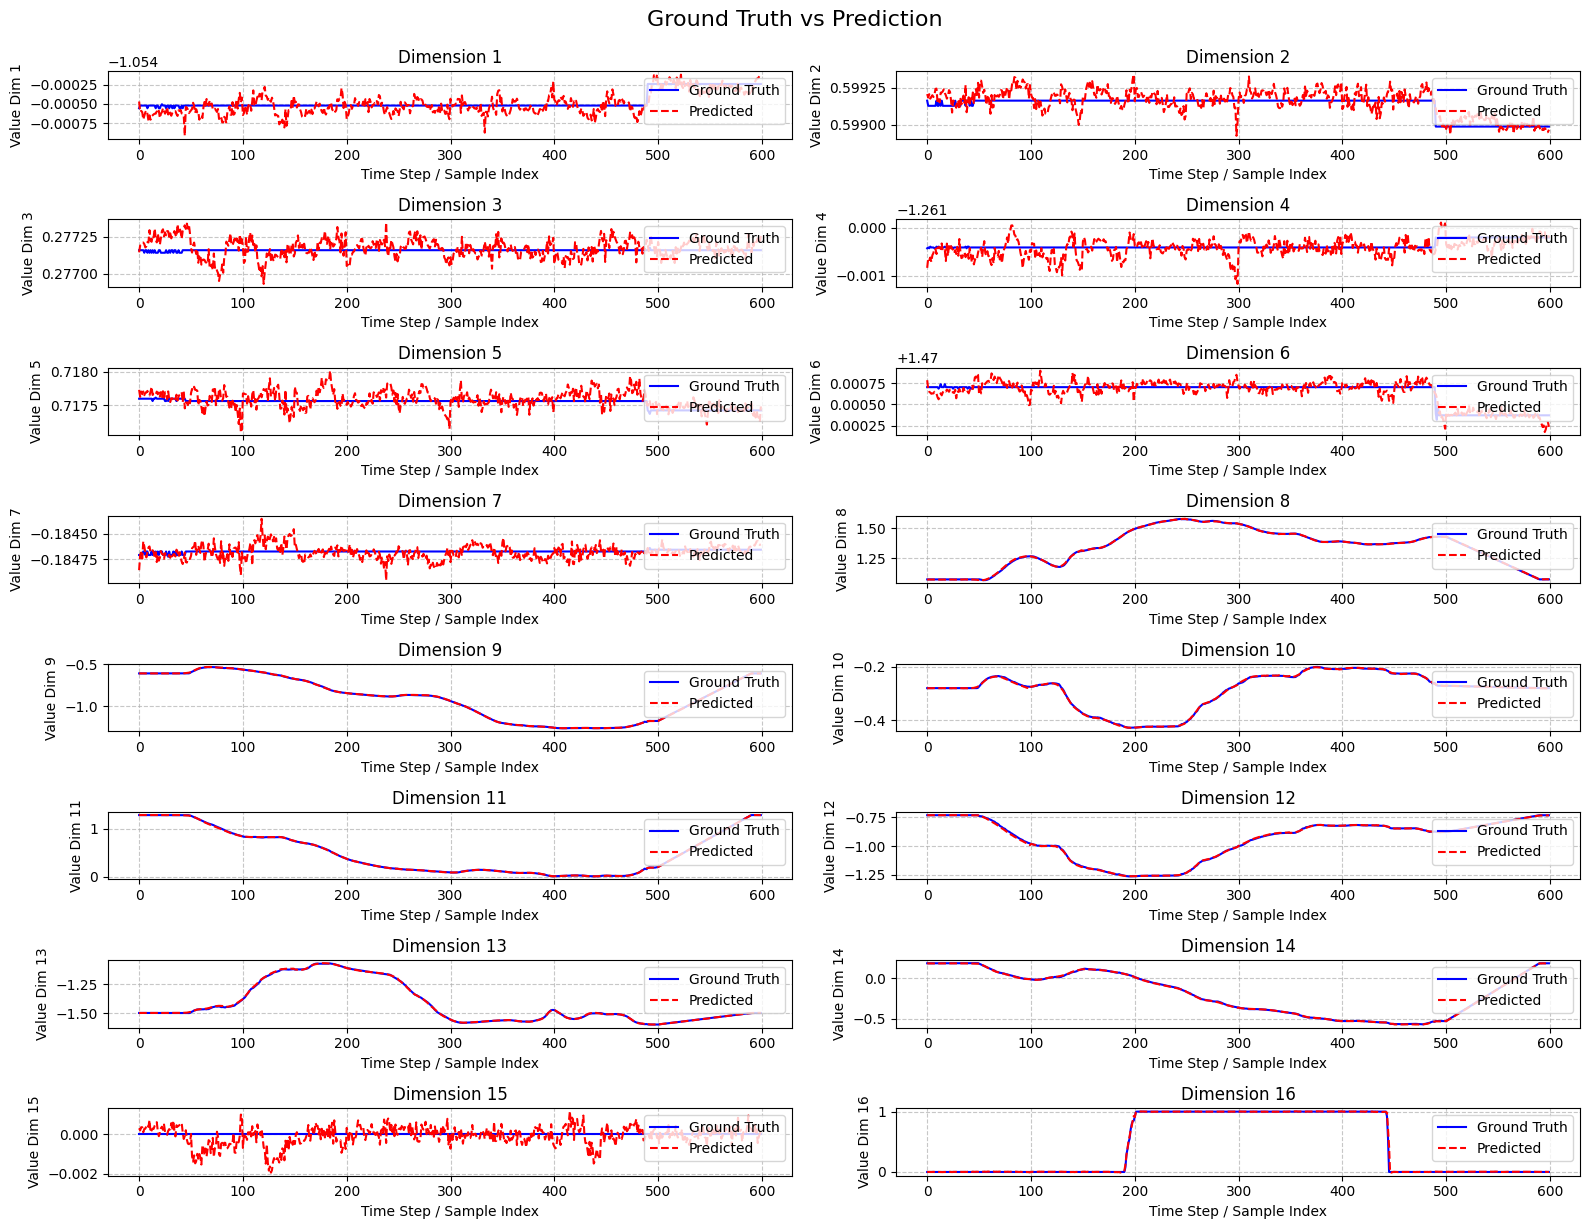

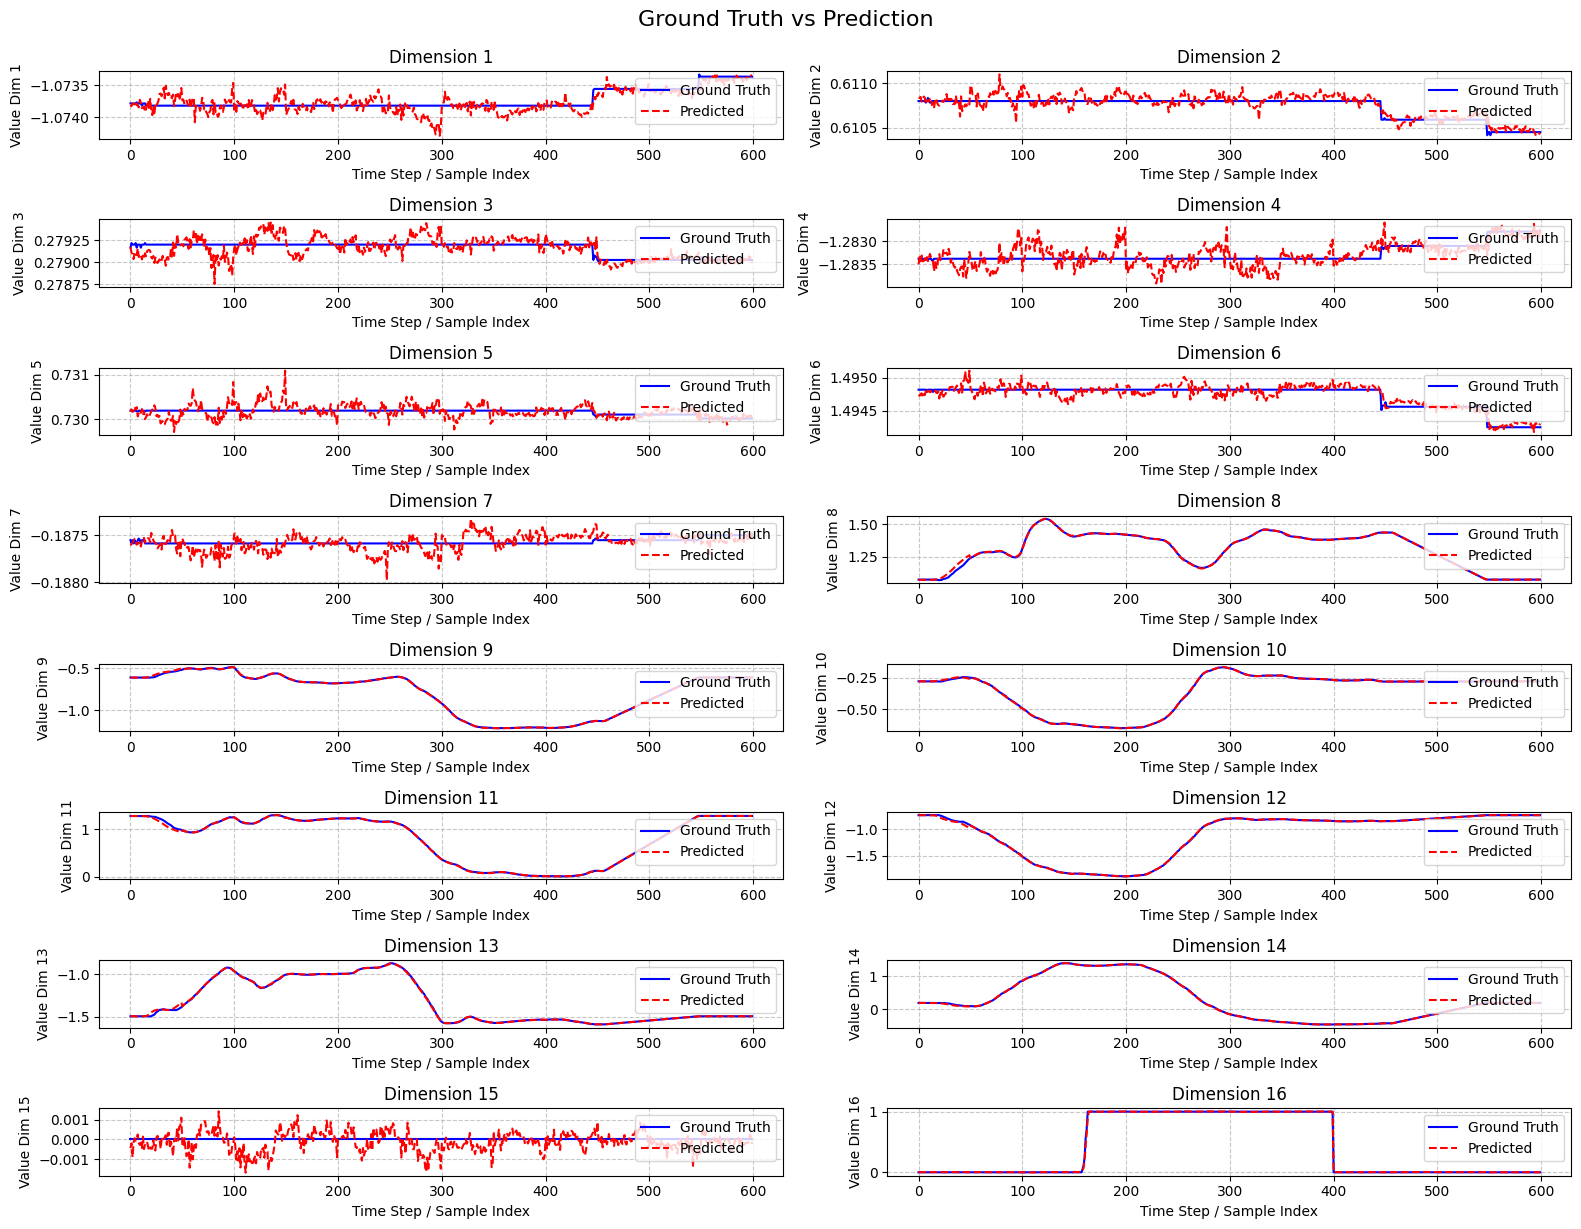

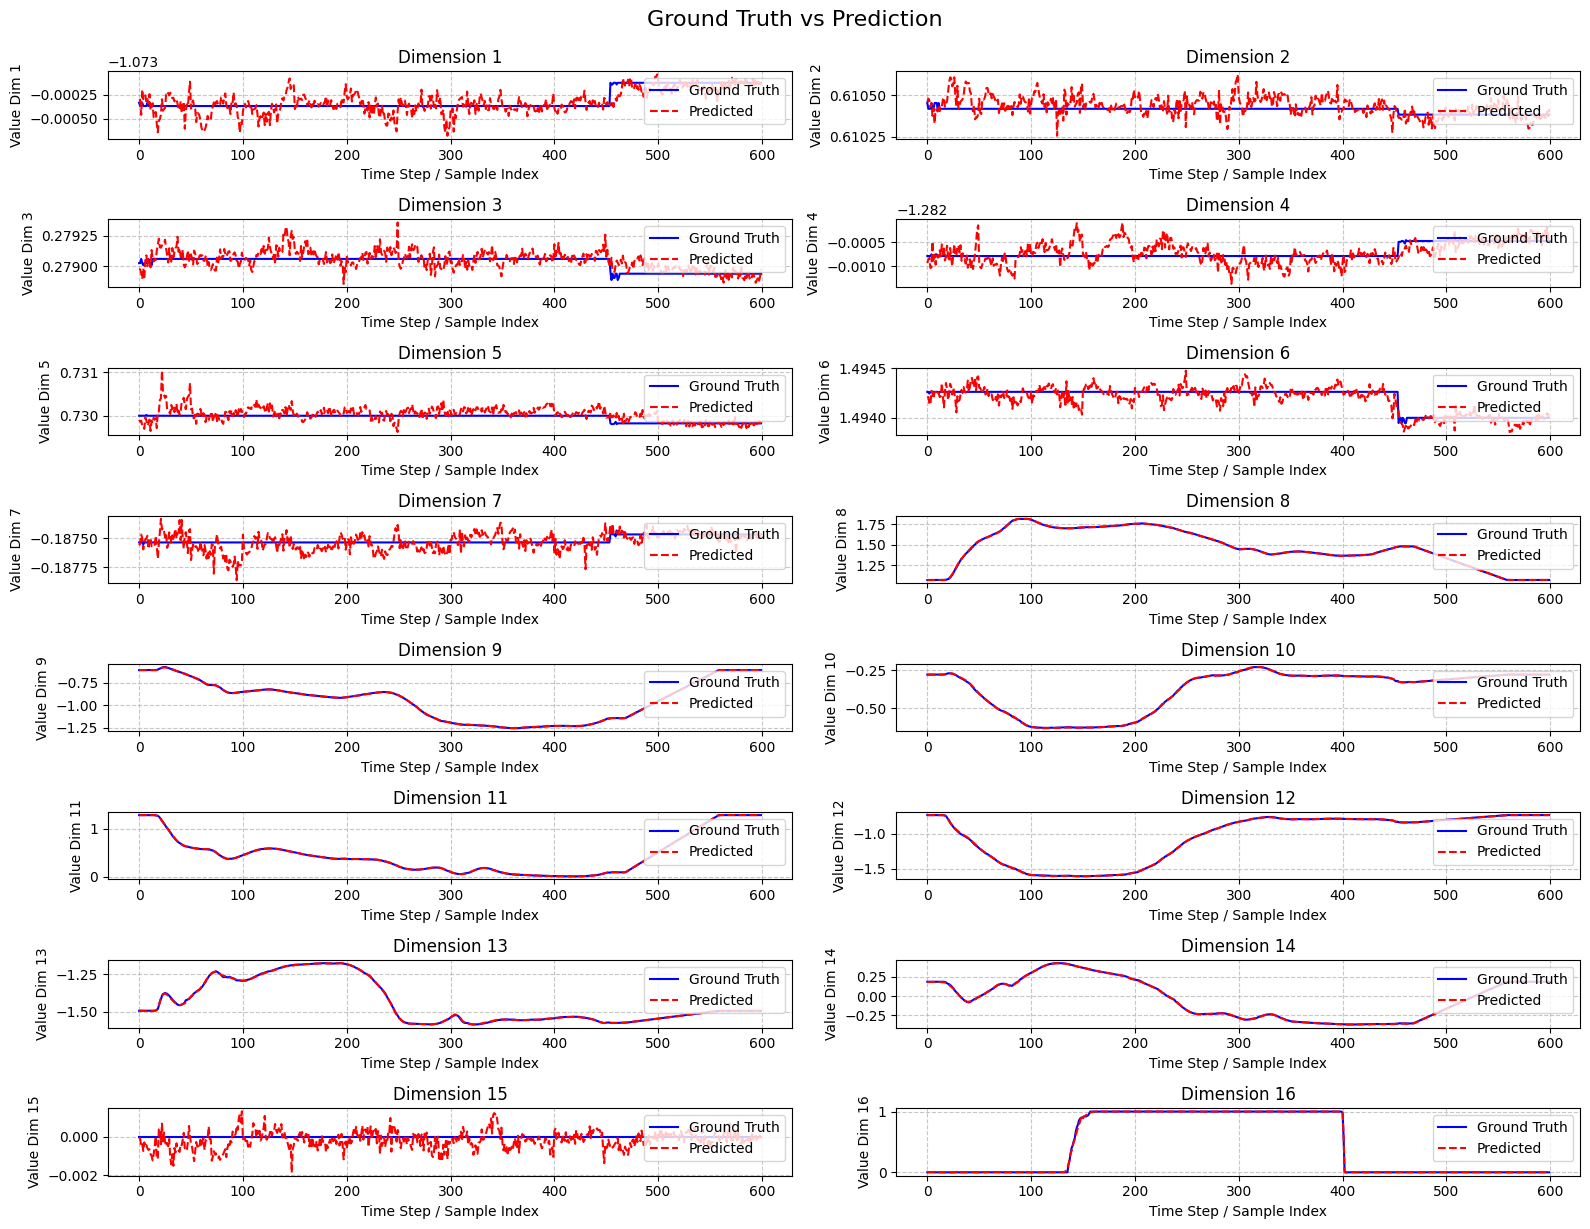

In [7]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pprint import pp

from_ids = np.asarray(dataset.meta.episodes['dataset_from_index']).tolist()
to_ids = np.asarray(dataset.meta.episodes['dataset_to_index']).tolist()
total_num_episodes = dataset.num_episodes

output_dir = Path(f"outputs/internvla_a1_3b/open_loop_results/last/{Path(cfg.dataset.repo_id).name}")
(output_dir / "plots").mkdir(exist_ok=True, parents=True)

num_episodes_infer = 3
metric_mse = []
mse_joint = []
mse_gripper = []
for ep_id in range(min(total_num_episodes, num_episodes_infer)):
    print(f"episode: {ep_id}")
    print(f"from_idx: {from_ids[ep_id]}, to_idx: {to_ids[ep_id]}")
    action_gt_list = []
    action_pred_list = []
    state_list = []
    for idx in range(from_ids[ep_id], to_ids[ep_id], config.chunk_size):
        print(f"compute sample {idx}")
        sample = dataset[idx]
        inputs = {}
        for key in sample.keys():
            if key == 'task':
                inputs[key] = [sample[key]]
            elif sample[key].dtype == torch.int64 or sample[key].dtype == torch.bool:
                inputs[key] = sample[key][None].cuda()
            else:
                inputs[key] = sample[key][None].cuda().to(dtype=dtype)
        with torch.no_grad():
            action_pred, _ = policy.predict_action_chunk(inputs, decode_image=False)
            action_pred = action_pred[0, :, :16]
            action_gt = inputs['action'][0, :, :16]
            action_gt_list.append(action_gt)
            action_pred_list.append(action_pred.clone())
            state_list.append(inputs[OBS_STATE].clone().repeat(config.chunk_size, 1)[:, :16])
    action_gt_tensor = torch.cat(action_gt_list, dim=0)
    action_gt_tensor = act_unnorm_fn({ACTION: action_gt_tensor})[ACTION]
    action_pred_tensor = torch.cat(action_pred_list, dim=0)
    action_pred_tensor = act_unnorm_fn({ACTION: action_pred_tensor})[ACTION]
    if action_mode == 'delta':
        state_tensor = torch.cat(state_list, dim=0)
        state_tensor = state_unnorm_fn({OBS_STATE: state_tensor})[OBS_STATE]
        action_pred_tensor[:, :14] += state_tensor[:, :14]
        action_gt_tensor[:, :14] += state_tensor[:, :14]
    action_gt_tensor = action_gt_tensor.to(torch.float32)
    action_pred_tensor = action_pred_tensor.to(torch.float32)
    metric_mse.append(float(F.mse_loss(action_gt_tensor, action_pred_tensor, reduction='mean').detach().cpu().numpy()))
    mse_joint.append(float(F.mse_loss(action_gt_tensor[:, :14], action_pred_tensor[:, :14], reduction='mean').detach().cpu().numpy()))
    mse_gripper.append(float(F.mse_loss(action_gt_tensor[:, 14:], action_pred_tensor[:, 14:], reduction='mean').detach().cpu().numpy()))
    action_gt_numpy = action_gt_tensor.detach().cpu().numpy()
    action_pred_numpy = action_pred_tensor.detach().cpu().numpy()
    fig, axs = plt.subplots(8, 2, figsize=(16, 12))
    axs = axs.ravel()
    num_dimensions = action_gt_numpy.shape[1]
    x_values = np.arange(action_gt_numpy.shape[0])
    for dim in range(num_dimensions):
        axs[dim].plot(x_values, action_gt_numpy[:, dim], label='Ground Truth', color='blue', linewidth=1.5)
        axs[dim].plot(x_values, action_pred_numpy[:, dim], label='Predicted', color='red', linestyle='--', linewidth=1.5)
        axs[dim].set_title(f'Dimension {dim+1}')
        axs[dim].set_xlabel('Time Step / Sample Index')
        axs[dim].set_ylabel(f'Value Dim {dim+1}')
        axs[dim].legend(loc='upper right')
        axs[dim].grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.suptitle('Ground Truth vs Prediction', fontsize=16, y=1.02)
    plt.savefig(output_dir / "plots" / f"qwena1_open_loop_ep{ep_id}.jpg")
log = {
    "MSE": metric_mse, 
    "Average MSE": np.mean(metric_mse), 
    "MSE on joints": mse_joint, 
    "Average MSE on joints": np.mean(mse_joint), 
    "MSE on gripper": mse_gripper, 
    "Average MSE on gripper": np.mean(mse_gripper), 
}
write_json(log, output_dir/"log.json")
pp(log)